In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('dark_background')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=0)

array([3.04470101, 0.63298709, 0.65432751, 1.5175129 , 0.78085325,
       0.6341433 , 0.87459994, 1.00571173, 0.68504912, 1.01402755,
       0.63915968, 0.65825195, 0.66197261, 1.04407087, 2.80167096,
       0.80280225, 0.83361601, 0.67170434, 0.66538914, 0.48316792,
       0.5704564 , 0.52324962, 1.10463661, 1.22121747, 0.52581269,
       0.58765684, 0.50016525, 3.22377082, 0.69175819, 1.20546935,
       4.12656194, 0.67824499, 1.75265207, 2.67871074, 1.18177785,
       1.11429053, 0.44422598, 0.63481357, 0.87829422, 0.30881013,
       1.04058779, 0.68213382, 0.38948335, 0.74921793, 0.97165063,
       1.27478184, 0.9820337 , 0.50643875, 0.39695896, 0.53155178,
       1.06668606, 1.25653031, 0.60235276, 0.41815181, 1.51938207,
       0.82304881, 0.99505599, 0.47844257, 0.57760229, 1.59708697,
       0.55656234, 0.52596506])

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
tmat.sample(2)

array([[[0.87262083, 0.12737917, 0.        , 0.        ],
        [0.        , 0.81594638, 0.18405362, 0.        ],
        [0.        , 0.        , 0.95250375, 0.04749625],
        [0.        , 0.        , 0.        , 1.        ]],

       [[0.88262446, 0.11737554, 0.        , 0.        ],
        [0.        , 0.63286832, 0.36713168, 0.        ],
        [0.        , 0.        , 0.93536948, 0.06463052],
        [0.        , 0.        , 0.        , 1.        ]]])

In [4]:
T = tmat.sample(1)
f = [0.8,0,0,0]
for i in range(10):
    f = f @ T[0]
    print(f, np.sum(f))

[0.4 0.4 0.  0. ] 0.8
[0.2        0.53133399 0.06866601 0.        ] 0.8
[0.1        0.54012253 0.15445151 0.00542595] 0.7999999999999999
[0.05       0.49740239 0.23496698 0.01763064] 0.8
[0.025      0.43701579 0.30178659 0.03619762] 0.8000000000000002
[0.0125     0.37449547 0.35295989 0.06004465] 0.8
[0.00625    0.3164577  0.38935694 0.08793537] 0.7999999999999999
[0.003125   0.26525798 0.41291486 0.11870216] 0.8
[0.0015625  0.22128496 0.42582204 0.15133049] 0.8
[0.00078125 0.18407933 0.43016068 0.18497875] 0.7999999999999999


In [5]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=5): #seeds:
            start[i,j,compartments.index('I')] = np.abs(ss.norm.rvs(loc=0.05, scale=0.01))
    return start

In [6]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 1
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = np.tile(R[np.newaxis,:,:], [N,1,1])
    infect = maxentep.contact_infection_func(tf.constant([np.random.uniform(0.01,0.25) for _ in range(N)]),
                                            infections_compartments)
    T = tmat.sample(N)
    model = MetaModel(start, Rmat, T, infect)
    outs.append(model.run(1000))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.32s/it]

(256, 1000, 62, 5)


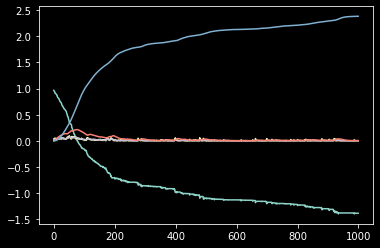

In [7]:
plt.plot(trajs[2,:,0,:])

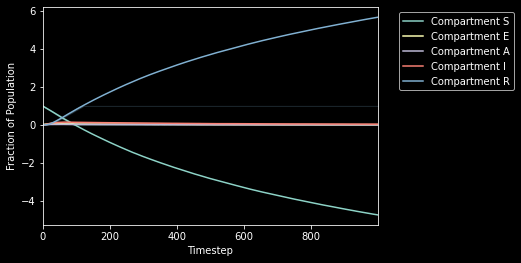

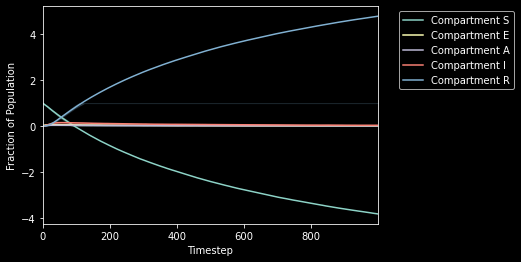

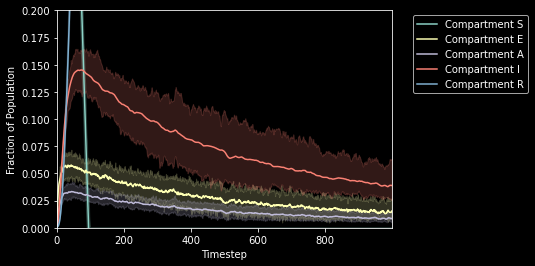

In [8]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

In [9]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,900, 1, 4],
    [0.6, 0, 250, 34, 4],
    [0.4, 0, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    r = maxentep.Restraint(lambda traj: traj[traj_index], value, p)
    laplace_restraints.append(r)

In [10]:
sigmas = np.array([r.prior.sigma for r in laplace_restraints], dtype=np.float32)
sigmas = np.tile(sigmas[np.newaxis, :], [trajs.shape[0], 1])
sigmas.shape

(256, 5)

In [11]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_absolute_error')

In [12]:
history = model.fit(trajs, batch_size=16, epochs=100)

Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 1.1771 - output_2_loss: 1.1771
Epoch 2/100
16/16 [==============================] - 0s 1000us/step - loss: 1.1415 - output_2_loss: 1.1415
Epoch 3/100
16/16 [==============================] - 0s 1ms/step - loss: 1.1521 - output_2_loss: 1.1521
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 1.1306 - output_2_loss: 1.1306
Epoch 5/100
16/16 [==============================] - 0s 1ms/step - loss: 1.0948 - output_2_loss: 1.0948
Epoch 6/100
16/16 [==============================] - 0s 937us/step - loss: 1.0643 - output_2_loss: 1.0643
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 1.0440 - output_2_loss: 1.0440
Epoch 8/100
16/16 [==============================] - 0s 1000us/step - loss: 0.9911 - output_2_loss: 0.9911
Epoch 9/100
16/16 [==============================] - 0s 972us/step - loss: 0.9289 - output_2_loss: 0.9289
Epoch 10/100
16/16 [==============================] - 

16/16 [==============================] - 0s 1ms/step - loss: 0.6754 - output_2_loss: 0.6754
Epoch 79/100
16/16 [==============================] - 0s 1ms/step - loss: 0.6881 - output_2_loss: 0.6881
Epoch 80/100
16/16 [==============================] - 0s 1000us/step - loss: 0.6685 - output_2_loss: 0.6685
Epoch 81/100
16/16 [==============================] - 0s 875us/step - loss: 0.6824 - output_2_loss: 0.6824
Epoch 82/100
16/16 [==============================] - 0s 938us/step - loss: 0.6951 - output_2_loss: 0.6951
Epoch 83/100
16/16 [==============================] - 0s 1ms/step - loss: 0.6697 - output_2_loss: 0.6697
Epoch 84/100
16/16 [==============================] - 0s 1000us/step - loss: 0.6903 - output_2_loss: 0.6903
Epoch 85/100
16/16 [==============================] - 0s 937us/step - loss: 0.6703 - output_2_loss: 0.6703
Epoch 86/100
16/16 [==============================] - 0s 1000us/step - loss: 0.6703 - output_2_loss: 0.6703
Epoch 87/100
16/16 [==============================] -

In [13]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer (ReweightLaye multiple                  5         
_________________________________________________________________
avg_layer (AvgLayer)         multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [14]:
history.history.keys()

dict_keys(['loss', 'output_2_loss'])

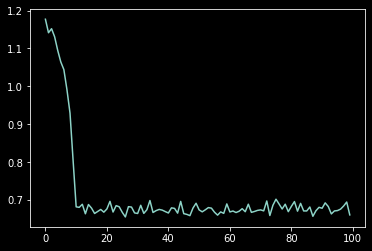

In [15]:
plt.plot(history.history['loss'])

TensorShape([256])

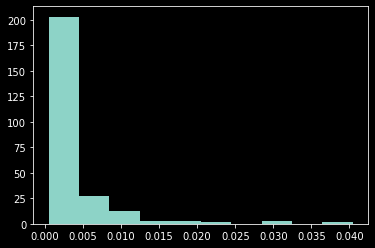

In [16]:
weights = model.traj_weights
plt.hist(weights)
weights.shape

In [17]:
#patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [18]:
#patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [19]:
laplace_restraints[0].prior.expected(model.lambdas[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

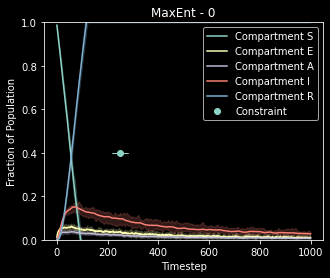

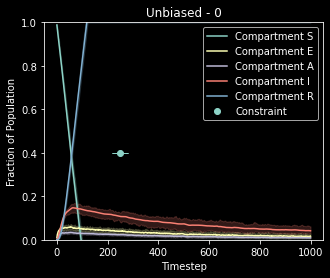

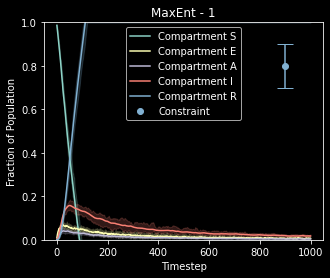

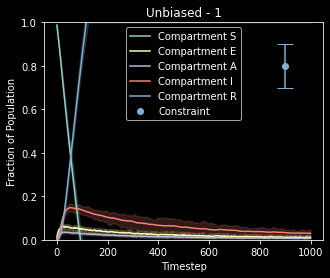

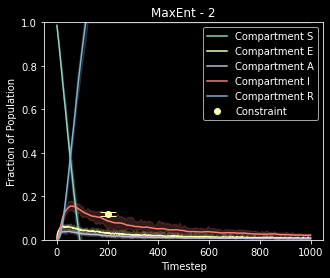

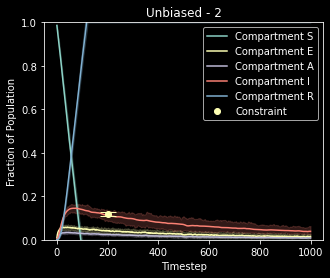

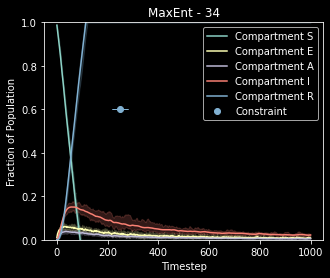

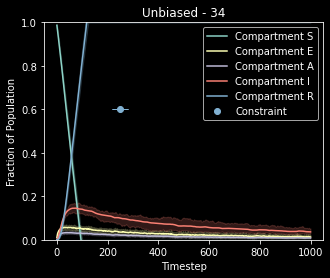

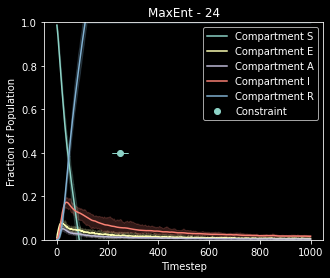

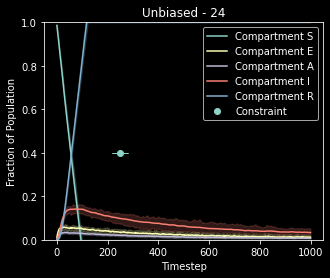

In [20]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()